In [ ]:
## Cosme's original code. Kept for reference.

In [48]:
#### Reclaculating FGCO2

In [49]:
import xarray as xr
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import cartopy.crs as ccrs
from spectrum import *

## I -  Create files

In [50]:
def create_file_name_variable(path_name, var, start_date, end_date):
    file_name = path_name%(var) 
    return file_name + start_date + '-' + end_date + '.nc'

# Vars looked at

var_names = ['tos', 'sos', 'siconc', 'sfcWind', 'dpco2', 'fgco2']
#var_names = ['fgco2', 'siconc']
method_var = {'tos' : 'mean', 'sos' : 'mean', 'siconc' : 'mean', 'sfcWind' : 'mean', 'dpco2' : 'mean', 'fgco2' : 'sum', 'mlotst' : 'mean'}

units = {'tos' : 'Celcius', 'sos' : 'g/kg', 'siconc' : '%', 'sfcWind' : 'm/s', 'dpco2' : 'Pa', 'fgco2' : 'kg/m2/s'}

# Files complete

path_yearmean = '/data/cmosneron/recalc_fgco2/%s_M_360x180.nc'

In [51]:
# Get files names and start and end months

files_vars = dict()

for var in var_names:
    files_vars.update({var : path_yearmean%var})
    


## II -  Def Functions

In [52]:
def spatial_integ(data_1D, nb_of_cells, area_1D):
    # Takes a 1D array returns the spatially integrated data
    # The 1D array corresponds to a temporal grid map with its shape converted to 1D
    temp = np.reshape(data_1D,(-1, nb_of_cells))
    area_1D_reshape = np.broadcast_to(area_1D,(temp.shape[0], temp.shape[1]))
    temp = temp * area_1D_reshape
    temp = temp.sum(axis = 1)
    return temp

def annual_mean(data_1D):
    # Takes a 1D array returns the annually meaned data
    # The 1D array corresponds to a temporal grid map with its shape converted to 1D

    temp = np.reshape(data_1D,(-1, 12))
    temp = temp.mean(axis = 1)
    return temp

def spatial_average(data_1D, nb_of_cells, area_1D):
    # Takes a 1D array returns the spatially averaged data
    # The 1D array corresponds to a temporal grid map with its shape converted to 1D

    temp = np.reshape(data_1D,(-1, nb_of_cells))    
    area_1D_reshape = np.broadcast_to(area_1D,(temp.shape[0], temp.shape[1]))
    temp = temp * area_1D_reshape
    temp = temp.sum(axis = 1) / area_1D.sum()
    return temp


def moving_average(x, N, mode = 'valid', Fill = True):
    '''
    Takes an array x, does a rolling average on the array, with a window size N. 
    Returns an array with the rolling averages. If Fill = True, the output will be of the same length as  x
    and will be centered.
    '''
    meaned = np.convolve(x, np.ones((N,))/N, mode='valid') 
    
    if Fill:
        meaned_temp = np.concatenate([np.ones(N//2) * np.nan, meaned])
        meaned = np.concatenate([meaned_temp, np.ones(len(x) - len(meaned_temp)) * np.nan])
        
    return meaned

def clean_ts_for_spectral_analysis(var_arr, rescale = False, check = False):
    '''
    This function takes in an array and return the data with the avg and linear trend taken out.
    If rescale True, the ts will be rescaled between -100 and 100. This allows to compare PSD between variables
    '''
    N = len(var_arr)
            
    var_minus_mean = var_arr - var_arr.mean()
    X = np.arange(0,N,1).reshape((-1,1))
    
    model = LinearRegression()
    model.fit(X,var_minus_mean)
    trend = model.predict(X)
    detrend = var_minus_mean - trend
    
    if check:
        
        fig,ax = plt.subplots(figsize = (15,5))
        ax.plot(np.arange(0,N,1),var_minus_mean, label = 'minus_mean')
        ax.plot(np.arange(0,N,1),trend, label = 'trend')    
        plt.show()
    
        fig,ax = plt.subplots(figsize = (15,5))
        ax.plot(np.arange(0,N,1),detrend, label = 'detrend')    
        plt.show()
    
    if rescale:
        maxima = np.max(xr.ufuncs.fabs(detrend))
        detrend = detrend / maxima * 100
    
    if rescale:
        maxima = np.max(xr.ufuncs.fabs(detrend))
        detrend = detrend / maxima * 100
        
    return detrend


## III -  Get data from zone of interest

In [53]:
time_segs = [(0,12000,12000), (12000, 24000, 12000)]
time_size = 12000

In [54]:
# Get lons, lats, time and area array
data = xr.open_dataset(files_vars['fgco2'], decode_times = False).isel(time = slice(0, 1))

mask_ocean = ~np.isnan(data['fgco2'].data[0,:,:])

lons = data['lon'].data
lats = data['lat'].data

del data

area = np.cos(lats * np.pi / 180)
area2D = np.transpose(np.asarray([area]*360))

print(area.shape, area2D.shape)


(180,) (180, 360)


In [55]:
### Input target coordinates
lon1, lon2 = 290., 359.
lat1, lat2 = 45.,70.

## Creat mask lat_lon
# lat_mask = mask on lats to keep target coordinates
# lon_mask = mask on lons to keep target coordinates

if lon1 < lon2:
    lonmask = (lons >= lon1) & (lons <= lon2)
    
elif lon1 > lon2:
    lonmask = (lons >= lon1) | (lons <= lon2)

elif lon1 == lon2:
    lonmask = (lons == lon1) & (lons == lon2)
    
if lat1 != lat2:
    latmask = (lats >= lat1) & (lats <= lat2)
    
if lat1 == lat2:
    latmask = (lats == lat1) & (lats == lat2)

### Create mask on ice 
# Get mask for area sea-ice cov > 5
mask_ice = xr.open_dataset(files_vars['siconc'], decode_times = False).isel(time = slice(0, 10000)).mean('time')['siconc'].data
ice_covering = mask_ice > 5

### Create global mask combining lats, lons and sea-ice condition ==> output is twodmask
masking_ice = False
masking_ice_opposite = False

if masking_ice:
    twodmask = ~(latmask[:, None] & lonmask[None, :] & mask_ocean & ice_covering)
    area_masked = np.ma.masked_array(area2D, twodmask)
    area_masked_1D = area_masked[area_masked.mask == False]
    nb_of_cells = area_masked_1D.size
    print(area_masked_1D.size)

elif masking_ice_opposite:
    ice_covering2 = ~ice_covering
    twodmask = ~(latmask[:, None] & lonmask[None, :] & mask_ocean & ice_covering2)
    area_masked = np.ma.masked_array(area2D, twodmask)
    area_masked_1D = area_masked[area_masked.mask == False]
    nb_of_cells = area_masked_1D.size
    print(area_masked_1D.size)
    
else:
    twodmask = ~(latmask[:, None] & lonmask[None, :] & mask_ocean)
    area_masked = np.ma.masked_array(area2D, twodmask)
    area_masked_1D = area_masked[area_masked.mask == False]
    nb_of_cells = area_masked_1D.size
    print(area_masked_1D.size)

    
#Mask for plotting

lons_used = lonmask[lonmask]
lats_used = latmask[latmask]
twodmask_plotting = ~(latmask[:, None] & lonmask[None, :])
area_masked_plotting = np.ma.masked_array(area2D, twodmask_plotting)
area_masked_1D_plotting = area_masked_plotting[area_masked_plotting.mask == False]
area_mask_reduced_plotting = area_masked_1D_plotting.reshape((lons_used.size), (lats_used.size))
area_masked_look_at = np.ma.masked_array(area2D, twodmask)


1268


In [56]:
## Monthly data
stock_var_compute = dict()

for time_bounds in time_segs:
    if time_bounds[0] == 0 :
        for name in var_names:
#             if name != 'fgco2': continue
            # Get all data and filter it
            print('--Getting data for %s for timesteps %s'%(name, time_bounds))
            data = xr.open_dataset(files_vars[name], decode_times = False).isel(time = slice(time_bounds[0], time_bounds[1]))[name].data
            
#             print(data.shape, type(data), data)
            
            threedmask = np.broadcast_to(twodmask, (time_bounds[2], 180, 360))
            data = np.ma.masked_array(data, threedmask)
            
#             print(data.shape, type(data), data)
            
            data = data[data.mask == False].data
            
#             print(data.shape, type(data), data)
        
            # Add it to the dict
            stock_var_compute.update({name : data})
            #del data
    else : 
        for name in var_names:
#             if name != 'fgco2': continue
            # Get all data and filter it
            print('Getting data for %s for timesteps %s'%(name, time_bounds))
            data = xr.open_dataset(files_vars[name], decode_times = False).isel(time = slice(time_bounds[0], time_bounds[1]))[name].data
            threedmask = np.broadcast_to(twodmask, (time_bounds[2], 180, 360))
            data = np.ma.masked_array(data, threedmask)
            data = data[data.mask == False].data
        
            # Add it to the dict
            data = np.concatenate([stock_var_compute[name], data])
            stock_var_compute.update({name : data})
            del data

--Getting data for tos for timesteps (0, 12000, 12000)
--Getting data for sos for timesteps (0, 12000, 12000)
--Getting data for siconc for timesteps (0, 12000, 12000)
--Getting data for sfcWind for timesteps (0, 12000, 12000)
--Getting data for dpco2 for timesteps (0, 12000, 12000)
--Getting data for fgco2 for timesteps (0, 12000, 12000)
Getting data for tos for timesteps (12000, 24000, 12000)
Getting data for sos for timesteps (12000, 24000, 12000)
Getting data for siconc for timesteps (12000, 24000, 12000)
Getting data for sfcWind for timesteps (12000, 24000, 12000)
Getting data for dpco2 for timesteps (12000, 24000, 12000)
Getting data for fgco2 for timesteps (12000, 24000, 12000)


In [57]:
# stock_var_compute['tos'].shape[0], 12000 * 180 * 360
print(type(stock_var_compute['tos']))

<class 'numpy.ndarray'>


# III - Area looked at : Figure 15

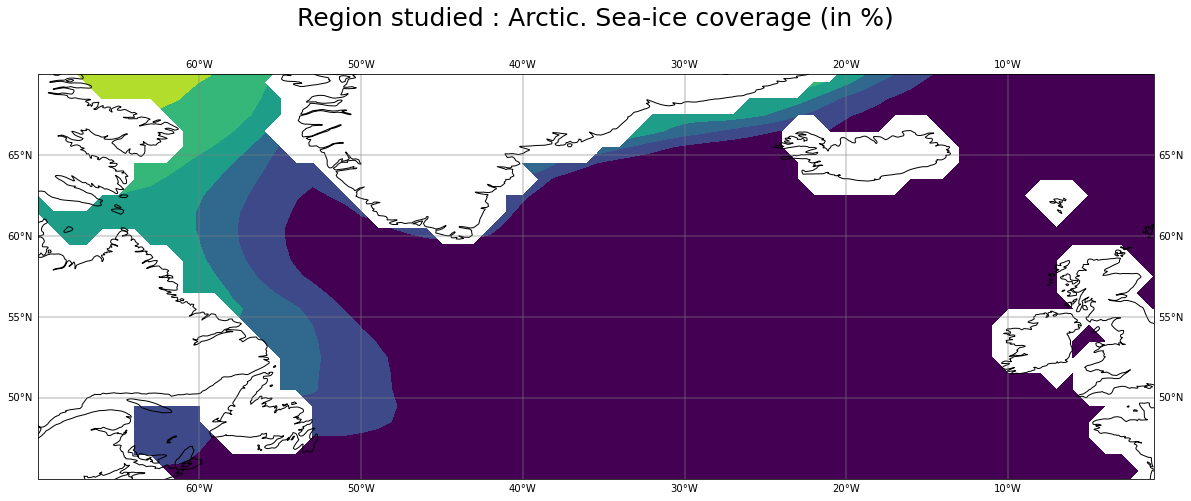

In [58]:
basin = 'North Atlantic'

fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection=ccrs.PlateCarree())

bounds = np.linspace(0,90,10)
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend = 'max')

ax.contourf(lons, lats, mask_ice, cmap = cmap, norm = norm) 
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

ax.coastlines()
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 2, color = 'gray', alpha = 0.3)
ax.set_title('Region studied : Arctic. Sea-ice coverage (in %)\n', fontsize = 25)

plt.show()

# IV -  Get timeseries

ts_stock2 = ts_stock
ts_stock_100y2 = ts_stock_100y
ts_stock_annual2 = ts_stock_annual

mlotst_data2 = mlotst_data
mlotst_data_100y2 = mlotst_data_100y
mlotst_data_100y_clean2 = mlotst_data_100y_clean 

In [59]:
# stock_var_compute['fgco2'] = stock_var_compute['fgco2'] * 60 * 60 * 24 * 365 / (10**12)
## MATT NOTE: I don't understand why this is being done. I've removed it for now

In [60]:
### Here we compute the annual time series of the variables in the considered region. 

ts_stock = dict() # ts_stock[var] contains the TS for var
ts_stock_100y = dict()  # ts_stock_100y[var] contains the TS with a 50 year window rolling mean for var
ts_stock_annual = dict() # ts_stock_annual[var] contains the raw TS minus the TS with a 50 year window rolling mean for var

### We also compute the corresponding variances, with nd without detrending the TS
variance_stock_raw = {'annual' : dict(), '100yr' : dict()}
variance_stock_detrend = {'annual' : dict(), '100yr' : dict()}

yr_window = 50

for name in var_names:
    ### Get TS
    ts_raw = annual_mean(stock_var_compute[name])
    if method_var[name] == 'mean':
        ts_raw = spatial_average(ts_raw, nb_of_cells, area_masked_1D)
    else : 
        ts_raw = spatial_integ(ts_raw, nb_of_cells, area_masked_1D)

    ### Compute variance of TS raw
    var_ts = np.var(ts_raw)
    var_ts_clean = np.var(clean_ts_for_spectral_analysis(ts_raw))
    
    ### Compute TS 100 yr average
    ts_100y = moving_average(ts_raw, yr_window)
    ts_100y_clean = ts_100y[~np.isnan(ts_100y)]
    
    ### Compute variance of TS 100-yr mean
    var_ts_100y = np.var(ts_100y_clean)
    var_ts_100y_clean = np.var(clean_ts_for_spectral_analysis(ts_100y_clean))

    ### Compute interannual only
    ts_interannual = ts_raw[~np.isnan(ts_100y)] - ts_100y_clean
    
    ### Stock TS in dicts
    ts_stock.update({name : ts_raw})
    ts_stock_100y.update({name : ts_100y_clean})
    ts_stock_annual.update({name : ts_interannual})
    
    ### Stock var in dicts
    variance_stock_raw['annual'].update({name : var_ts})
    variance_stock_detrend['annual'].update({name : var_ts_clean})
    variance_stock_raw['100yr'].update({name : var_ts_100y})
    variance_stock_detrend['100yr'].update({name : var_ts_100y_clean})
    
del ts_raw, ts_100y, ts_interannual

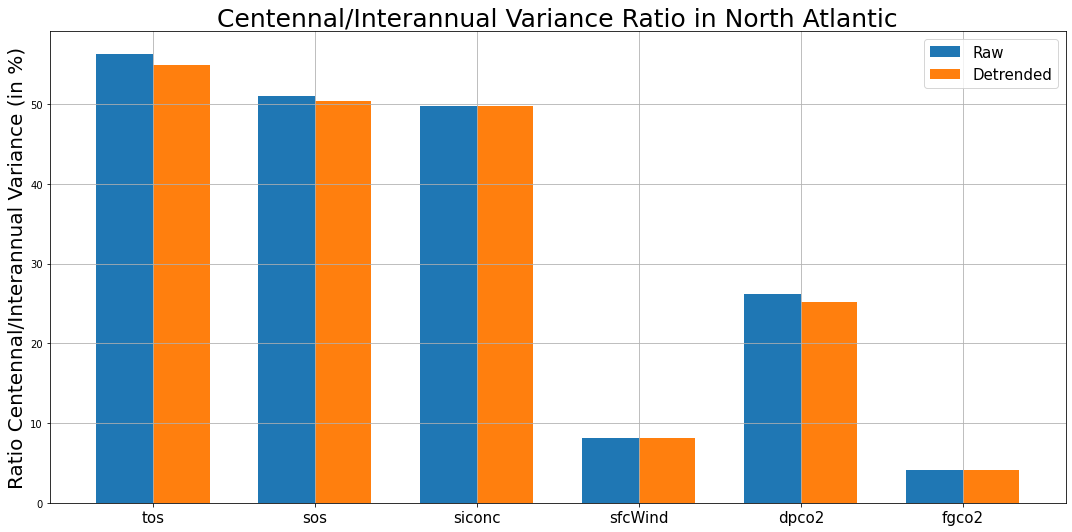

In [61]:
### Calcul rapport de variance
def get_variance_ratio(dictionnaire, list_var, window):
    list_temp = []
    for name in list_var:
        list_temp.append((dictionnaire['100yr'][name] - dictionnaire['annual'][name]/window) / dictionnaire['annual'][name] * 100)
    return list_temp

ratio_var_raw = get_variance_ratio(variance_stock_raw, var_names , yr_window)
ratio_var_clean = get_variance_ratio(variance_stock_detrend, var_names , yr_window)

width = 0.35
x = np.arange(len(var_names))

fig, ax = plt.subplots(figsize = (15,7.5))

rects1 = ax.bar(x - width/2, ratio_var_raw, width, label='Raw')
rects2 = ax.bar(x + width/2, ratio_var_clean, width, label='Detrended')
                
ax.set_ylabel('Ratio Centennal/Interannual Variance (in %)', fontsize = 20)
ax.set_title('Centennal/Interannual Variance Ratio in %s'%basin, fontsize = 25)
ax.set_xticks(x)
ax.set_xticklabels(var_names, fontsize = 15)
ax.legend(fontsize = 15)
ax.grid()
fig.tight_layout()
plt.show()

Plotting for tos


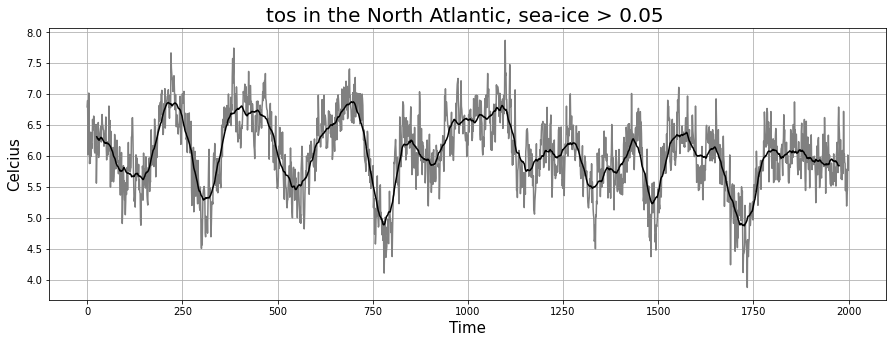

Plotting for sos


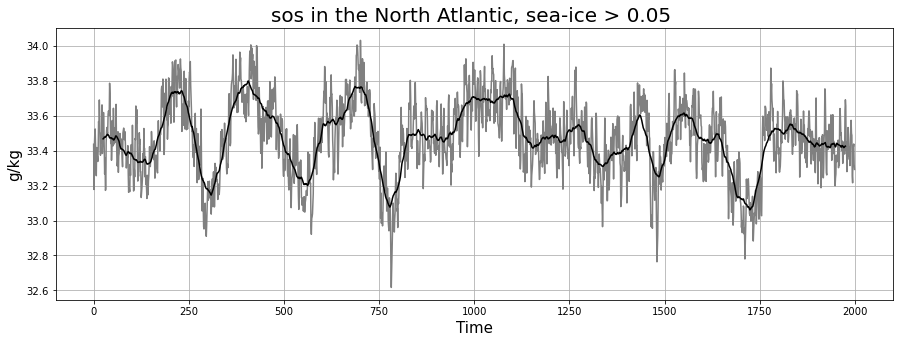

Plotting for siconc


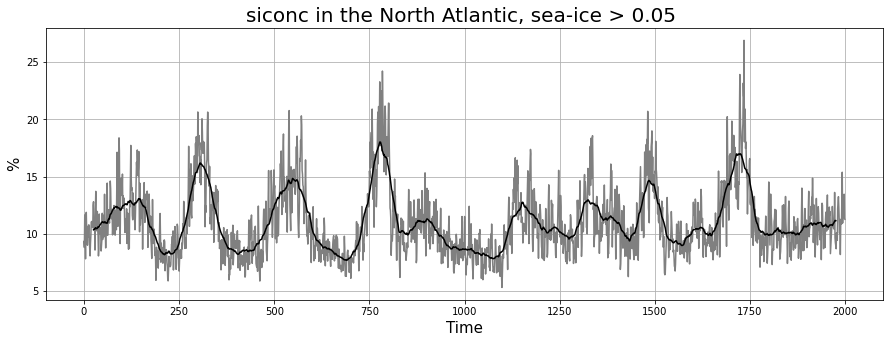

Plotting for sfcWind


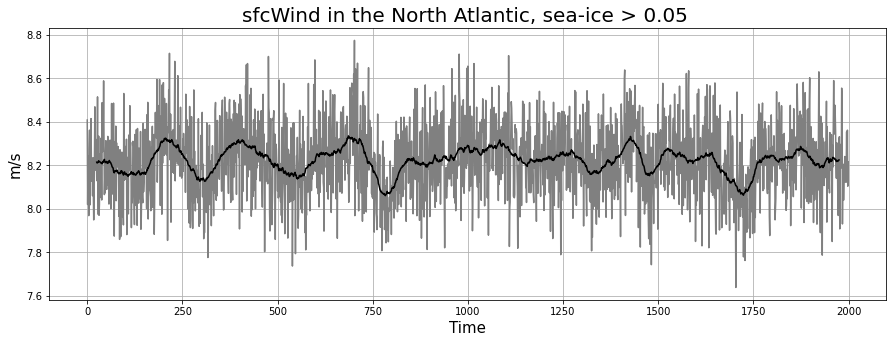

Plotting for dpco2


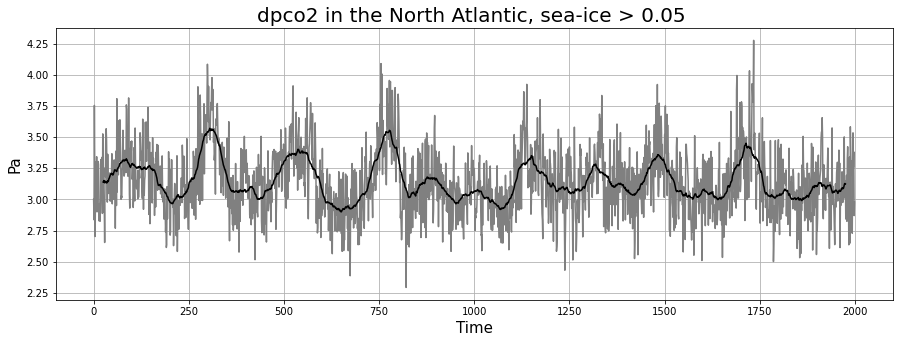

Plotting for fgco2


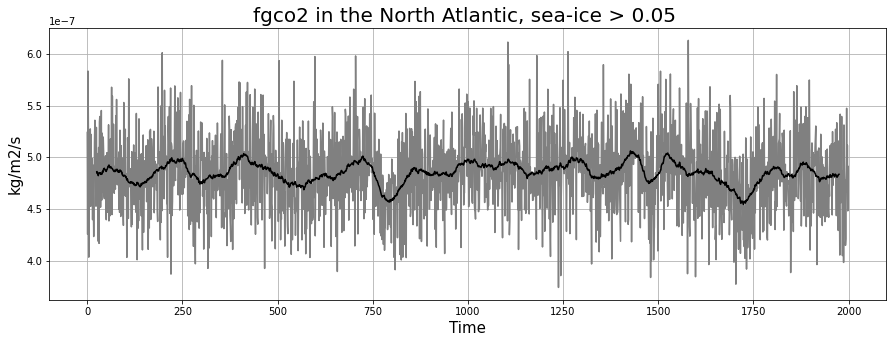

In [62]:
### Plot TS of variables in the region considered
for name in var_names:
    print('Plotting for %s'%name)
    ts_100y = moving_average(ts_stock[name], yr_window)
    

    fig, ax  = plt.subplots(figsize = (15,5))
    ax.plot(ts_stock[name] , c = 'grey')
    ax.plot(ts_100y, c = 'black')
    
    ax.grid()
    #plt.title('%s time series interannual \n'%name, fontsize = 20)
    ax.set_title('%s in the North Atlantic, sea-ice > 0.05 '%name, fontsize = 20)
    ax.set_ylabel(units[name], fontsize = 15)
    ax.set_xlabel('Time', fontsize = 15)

    plt.show()
    
# fig = plt.figure(figsize = (15,5))
# plt.plot(mlotst_data, c = 'grey')
# plt.plot(mlotst_data_100y, c = 'black')
    
# plt.grid()
# plt.title('Mlotst Time series, < 95 % \n', fontsize = 20)
# plt.show()
    

# V -  Compute FCO2 with several scenarios : Figure 17

In [63]:
### Define dictionnaries
var_names_looked_at = ['tos', 'sos', 'siconc', 'sfcWind', 'dpco2']


stock_contrib = dict()
list_contribution = ['K0_contribution', 'Wind_contribution', 'Sice_contribution', 'Schmidt_contribution', 'Dpco2_contribution'] 

stock_scenario = dict()
list_scenario = ['TOS_constant', 'SOS_constant', 'Wind_constant', 'Sice_constant', 'Dpco2_constant'] 

stock_variation = dict()
list_variation = ['Tos_variation', 'Sos_variation', 'Wind_variation', 'Sice_variation', 'Dpco2_variation', 'Wind_sos_variation', 'Wind_dpco2_variation', 'Wind_tos_variation']


constantes =  1000 * 0.01 / 3600. * 0.251
print(1/constantes)
    

1434.2629482071713


In [64]:
### Define functions

def compute_fgco2(stock_var_compute, stock_contrib = stock_contrib, keep_contrib = False, 
                  tos = 'tos', sos = 'sos', wind = 'sfcWind', dpco2 = 'dpco2', sea_ice = 'siconc'):
    '''
    Functions takes a dictionary with tos, sos, dpco2, wind and sea ice.
    Calculates the contributions of each input variable, and store them if keep_contrib = True
    Calculates the projected fgco2 on every grid cell, for each month
    '''
    ### Constantes
    rhop = 1025
    
    ### KO
    tos_kel = stock_var_compute[tos] + 273.15 
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + stock_var_compute[sos] * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)
    chemc = np.exp(zcek1) * 1e-6 * rhop / 1000
    del tos_kel, zcek1
    
    ### Schmidt Number
    ztc = np.minimum(35,stock_var_compute[tos])
    sch_co2 = 2116.8 - 136.25 * ztc + 4.7353 * ztc * ztc - 0.092307 * ztc * ztc *ztc + 0.0007555 * ztc * ztc * ztc *ztc
    del ztc
    
    ### Wind
    wind_contrib = (stock_var_compute[wind]*stock_var_compute[wind]) 
    sea_ice_contrib =(1 - stock_var_compute[sea_ice]/100)  

    ### Calcul
    fgco2_calc = wind_contrib * sea_ice_contrib * stock_var_compute[dpco2] * chemc * np.sqrt(660. / sch_co2) * constantes

    if keep_contrib == False:
        del chemc, sch_co2, zkgwan
    
    else:
        stock_contributions(stock_contrib, nb_of_cells, area_masked_1D, chemc, wind_contrib, sea_ice_contrib, sch_co2)
    
    return fgco2_calc


def stock_contributions(stock_contrib, nb_of_cells, area_masked_1D, chemc, wind_contrib, sea_ice_contrib, sch_co2):
    '''
    Functions takes the calculated contributions, converts them into a TS and stocks them in stock_contrib
    '''   
    chemc = annual_mean(chemc)
    chemc = spatial_average(chemc, nb_of_cells, area_masked_1D)
    stock_contrib.update({'K0_contribution' : chemc})
    del chemc
        
    wind_contrib = annual_mean(wind_contrib)
    wind_contrib = spatial_average(wind_contrib, nb_of_cells, area_masked_1D)
    stock_contrib.update({'Wind_contribution' : wind_contrib})
    del wind_contrib
        
    sea_ice_contrib = annual_mean(sea_ice_contrib)
    sea_ice_contrib = spatial_average(sea_ice_contrib, nb_of_cells, area_masked_1D)
    stock_contrib.update({'Sice_contribution' : sea_ice_contrib})
    del sea_ice_contrib
        
    schmidt = annual_mean(np.sqrt(660. / sch_co2))
    schmidt = spatial_average(schmidt, nb_of_cells, area_masked_1D)
    stock_contrib.update({'Schmidt_contribution' : schmidt})
    del schmidt
        
    dpco2 = annual_mean(stock_var_compute['dpco2'] )
    dpco2 = spatial_average(dpco2, nb_of_cells, area_masked_1D)
    stock_contrib.update({'Dpco2_contribution' : dpco2})
    del dpco2    
        
    
def compute_fgco2_scenario(stock_var_compute, stock_scenario, keep_scenario = True, tos = 'tos', sos = 'sos', wind = 'sfcWind', dpco2 = 'dpco2', sea_ice = 'siconc'):
    '''
    Functions takes a dictionary with tos, sos, dpco2, wind and sea ice.
    Calculates fgco2 for several scenarios, where eack variable is maintained constant
    The computation is done on ever each  grid cell, for each month
    '''
    ### Constantes
    rhop = 1025
    
    ### KO
    tos_kel = stock_var_compute[tos] + 273.15 
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + stock_var_compute[sos] * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)
    chemc = np.exp(zcek1) * 1e-6 * rhop / 1000
    
    tos_kel = stock_var_compute[tos] + 273.15 
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + 32 * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)
    chemc_sos_ct = np.exp(zcek1) * 1e-6 * rhop / 1000
    
    tos_kel = 8 + 273.15 
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + stock_var_compute[sos] * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)
    chemc_tos_ct = np.exp(zcek1) * 1e-6 * rhop / 1000
    del tos_kel, zcek1
    
    ### Schmidt Number
    ztc = np.minimum(35,stock_var_compute[tos])
    sch_co2 = 2116.8 - 136.25 * ztc + 4.7353 * ztc * ztc - 0.092307 * ztc * ztc *ztc + 0.0007555 * ztc * ztc * ztc *ztc
    del ztc
    
    ### Wind
    wind_contrib = (stock_var_compute[wind]*stock_var_compute[wind]) 
    sea_ice_contrib =(1 - stock_var_compute[sea_ice]/100)  

    ### Calcul
    if keep_scenario == False:
        del chemc, sch_co2, zkgwan
    
    else:
        stock_scenarios(stock_scenario, nb_of_cells, area_masked_1D, chemc, chemc_tos_ct, chemc_sos_ct, wind_contrib, sea_ice_contrib, sch_co2)
    
    return fgco2_calc

    
def stock_scenarios(stock_scenario, nb_of_cells, area_masked_1D, chemc, chemc_tos_ct, chemc_sos_ct, wind_contrib, sea_ice_contrib, sch_co2):
        
    chemc_scenario = annual_mean(sea_ice_contrib * chemc_tos_ct * wind_contrib * stock_var_compute['dpco2'])
    chemc_scenario = spatial_average(chemc_scenario, nb_of_cells, area_masked_1D)
    stock_scenario.update({'TOS_constant' : chemc_scenario})
    del chemc_scenario
    
    chemc_scenario = annual_mean(sea_ice_contrib * chemc_sos_ct * wind_contrib * stock_var_compute['dpco2'] * np.sqrt(660. / sch_co2))
    chemc_scenario = spatial_average(chemc_scenario, nb_of_cells, area_masked_1D)
    stock_scenario.update({'SOS_constant' : chemc_scenario})
    del chemc_scenario
        
    wind_scenario= annual_mean(sea_ice_contrib * stock_var_compute['dpco2'] * chemc  * np.sqrt(660. / sch_co2))
    wind_scenario = spatial_average(wind_scenario, nb_of_cells, area_masked_1D)
    stock_scenario.update({'Wind_constant' : wind_scenario})
    del wind_scenario
        
    sea_ice_scenario = annual_mean(wind_contrib * stock_var_compute['dpco2'] * chemc  * np.sqrt(660. / sch_co2))
    sea_ice_scenario = spatial_average(sea_ice_scenario, nb_of_cells, area_masked_1D)    
    stock_scenario.update({'Sice_constant' : sea_ice_scenario})
    del sea_ice_scenario
                
    dpco2_scenario = annual_mean(sea_ice_contrib * wind_contrib * chemc  * np.sqrt(660. / sch_co2))
    dpco2_scenario = spatial_average(dpco2_scenario, nb_of_cells, area_masked_1D)
    stock_scenario.update({'Dpco2_constant' : dpco2_scenario})
    del dpco2_scenario    

    
    del chemc, sch_co2, wind_contrib, sea_ice_contrib
    

def plot_contrib(contrib, title):
    fig = plt.figure(figsize = (15,5))
    plt.plot(contrib, c = 'grey')
    average_30y = moving_average(contrib, 100)
    plt.plot(average_30y, c = 'black')
    plt.grid()
    plt.title(title, fontsize = 20)
    plt.show()
    
def compute_fgco2_variation(stock_var_compute, stock_variation, tos = 'tos', sos = 'sos', wind = 'sfcWind', dpco2 = 'dpco2', sea_ice = 'siconc'):
    '''
    Functions takes a dictionary with tos, sos, dpco2, wind and sea ice.
    Calculates fgco2 for several scenarios, where only one variable is free
    The computation is done on ever each  grid cell, for each month
    '''
    
    ### Constantes
    rhop = 1025
    
    ### Constant contribution
    tos_kel = 280  ## SST in Kelvin
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + 34 * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)    
    chemc_constant_tos_sos = np.exp(zcek1) * 1e-6 * rhop / 1000
    
    ztc = 6.85
    sch_co2_constant = 2116.8 - 136.25 * ztc + 4.7353 * ztc * ztc - 0.092307 * ztc * ztc *ztc + 0.0007555 * ztc * ztc * ztc *ztc
    wind_constant = 70
    sea_ice_constant = 0.95
    dpco2_constant = 3.
    
    ### Contributions
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + stock_var_compute[sos] * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)
    chemc_tos_const = np.exp(zcek1) * 1e-6 * rhop / 1000
    
    tos_kel = stock_var_compute[tos] + 273.15 
    zcek1 = 9345.17/tos_kel - 60.2409 + 23.3585 * np.log(tos_kel*0.01) + 34 * (0.023517 - 0.00023656 * tos_kel + 0.0047036e-4 * tos_kel * tos_kel)
    chemc_sos_const = np.exp(zcek1) * 1e-6 * rhop / 1000
    
    ztc = np.minimum(35,stock_var_compute[tos])
    sch_co2 = 2116.8 - 136.25 * ztc + 4.7353 * ztc * ztc - 0.092307 * ztc * ztc *ztc + 0.0007555 * ztc * ztc * ztc *ztc
    
    ### Wind
    wind_contrib = (stock_var_compute[wind]*stock_var_compute[wind]) 
        
    #Sea ice contrib
    sea_ice_contrib = (1 - stock_var_compute[sea_ice])
    
    ## Constants used:
    # wind_constant, sea_ice_constant, dpco2_constant, chemc_sos_const, chemc_tos_const, chemc_constant_tos_sos, sch_co2_constant
        
    ### Calcul
    tos_variation = annual_mean(wind_constant * sea_ice_constant * dpco2_constant * chemc_sos_const * np.sqrt(660. / sch_co2) * constantes)
    tos_variation = spatial_average(tos_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Tos_variation' : tos_variation})
    del tos_variation
    
    sos_variation = annual_mean(wind_constant * sea_ice_constant * dpco2_constant * chemc_tos_const * np.sqrt(660. / sch_co2_constant) * constantes)
    sos_variation = spatial_average(sos_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Sos_variation' : sos_variation})
    del sos_variation
        
    wind_variation = annual_mean(wind_contrib * sea_ice_constant * dpco2_constant * chemc_constant_tos_sos * np.sqrt(660. / sch_co2_constant) * constantes)
    wind_variation = spatial_average(wind_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Wind_variation' : wind_variation})
    del wind_variation
        
    sea_ice_variation = annual_mean(wind_constant * sea_ice_contrib * dpco2_constant * chemc_constant_tos_sos * np.sqrt(660. / sch_co2_constant)* constantes)
    sea_ice_variation = spatial_average(sea_ice_variation, nb_of_cells, area_masked_1D)    
    stock_variation.update({'Sice_variation' : sea_ice_variation})
    del sea_ice_variation
        
    dpco2_variation = annual_mean(wind_constant * sea_ice_constant * stock_var_compute['dpco2'] * chemc_constant_tos_sos * np.sqrt(660. / sch_co2_constant)* constantes)
    dpco2_variation = spatial_average(dpco2_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Dpco2_variation' : dpco2_variation})
    del dpco2_variation
    
    Wind_sos_variation = annual_mean(wind_contrib * sea_ice_constant * dpco2_constant * chemc_tos_const * np.sqrt(660. / sch_co2_constant)* constantes)
    Wind_sos_variation = spatial_average(Wind_sos_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Wind_sos_variation' : Wind_sos_variation})
    del Wind_sos_variation
    
    Wind_tos_variation = annual_mean(wind_contrib * sea_ice_constant * dpco2_constant * chemc_sos_const * np.sqrt(660. / sch_co2)* constantes)
    Wind_tos_variation = spatial_average(Wind_tos_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Wind_tos_variation' : Wind_tos_variation})
    del Wind_tos_variation
    
    Wind_dpco2_variation = annual_mean(wind_contrib * sea_ice_constant * stock_var_compute['dpco2'] * chemc_constant_tos_sos * np.sqrt(660. / sch_co2_constant)* constantes)
    Wind_dpco2_variation = spatial_average(Wind_dpco2_variation, nb_of_cells, area_masked_1D)
    stock_variation.update({'Wind_dpco2_variation' : Wind_dpco2_variation})
    del Wind_dpco2_variation
            
    return fgco2_calc

def get_variance(dictionnaire, liste):
    variance = np.zeros(len(liste))
    for i, name in enumerate(liste):
        var1 = np.var(dictionnaire[name])
        variance[i] = var1
    return variance

In [65]:
## HERE I AM
# Testing making better "constant" versions of fields. Ideally keep them as fields using the seasonal cycle
# Things like chemc_sos_const, that have 2 input (tos, sos), will take a bit more consideration later
def repeating_seasonal_cycle(input_field):
    
    output_field = input_field.copy()
    
    return output_field

name = 'tos'
seasonal_cycle = repeating_seasonal_cycle(stock_var_compute[name])

print(seasonal_cycle.shape)

(30432000,)


In [66]:
### Calculate fgco2 and its contributions

fgco2_calc = compute_fgco2(stock_var_compute, keep_contrib = True)
fgco2_calc = annual_mean(fgco2_calc)
fgco2_calc = spatial_integ(fgco2_calc, nb_of_cells, area_masked_1D)
fgco2_calc_100yr = moving_average(fgco2_calc, yr_window, Fill = False)    

### Calculate fgco2 and its scenarios

compute_fgco2_scenario(stock_var_compute, stock_scenario, keep_scenario = True)

### Calculate fgco2 and its scenarios with only one variable 

compute_fgco2_variation(stock_var_compute, stock_variation)

### Add fgco2 to dicts
stock_contrib.update({'fgco2' : fgco2_calc})
stock_scenario.update({'fgco2' : fgco2_calc})
stock_variation.update({'fgco2' : fgco2_calc})

In [86]:
## units of  orig in are kg/m2/s of Carbon equivalent (or perhaps g/m2/s)
orig = stock_var_compute['fgco2'] * 60 * 60 * 24 * 365 / 1e3
orig = annual_mean(orig)
orig = spatial_average(orig, nb_of_cells, area_masked_1D)

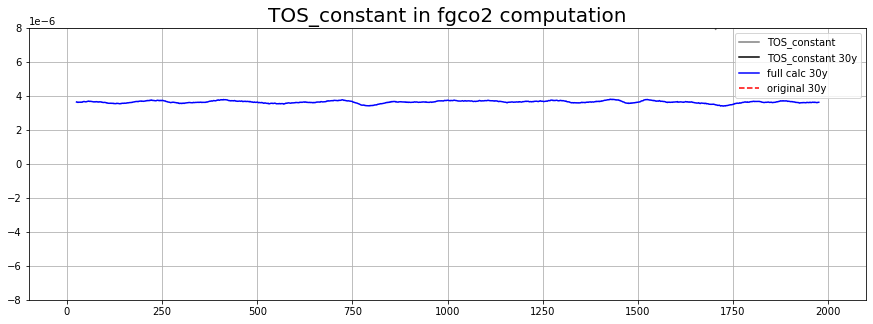

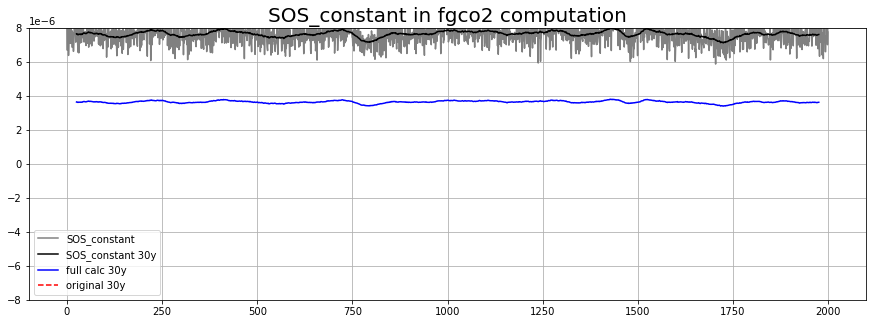

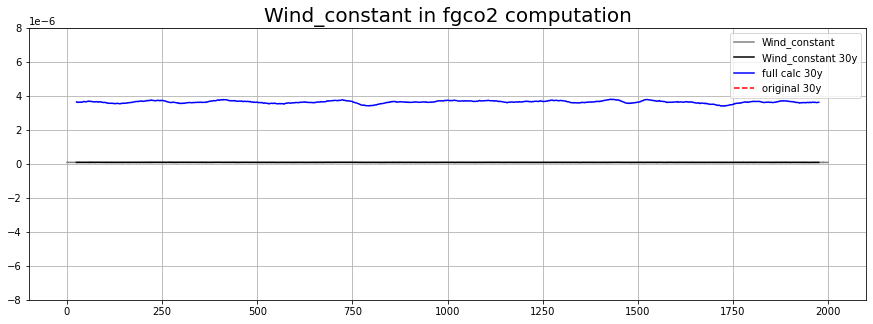

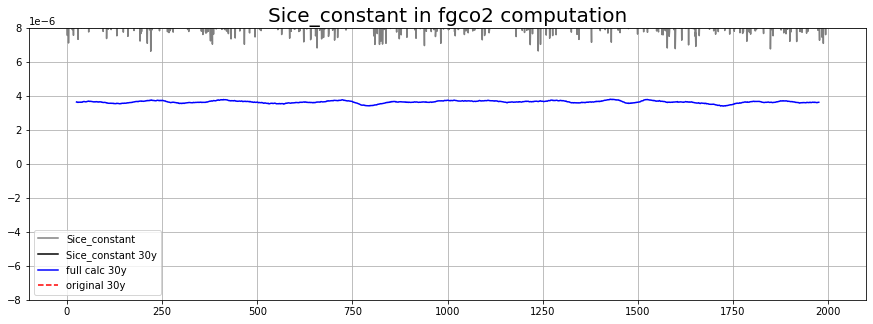

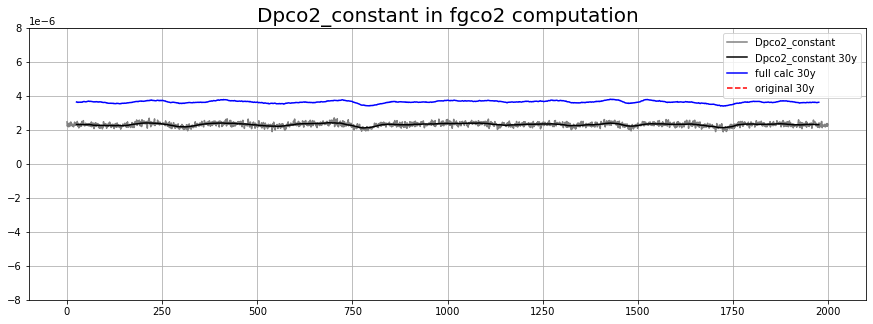

In [87]:
### Plot contributions
stock_scenario_centennal = dict()
stock_scenario_interannual = dict()

stock_scenario_interannual.update({'fgco2' : ts_stock_annual['fgco2']})
stock_scenario_centennal.update({'fgco2' : fgco2_calc_100yr})

ylim = np.array((-2e-6, 2e-6)) * 4

do_mean_adjust = False
for contrib in list_scenario:
    to_plot = stock_scenario[contrib]
    average_30y = moving_average(to_plot, yr_window)    
    
    full = stock_scenario['fgco2']
    full_30y = moving_average(full, yr_window)    
    full_30y_meanAdjusted = full_30y.copy()
    
    orig_30y = moving_average(orig, yr_window) 
    orig_30y_meanAdjusted = orig_30y.copy()
    
    ## This mean-adjuetment might be related to the fact that in the "keep-one-constant" approach,
    ## the values aren't time means but seemingly arbitrary values.
    mean_adjust_string = ''
    if do_mean_adjust:
        mean_adjust_string = ' mean-adjusted'
        full_30y_meanAdjusted -= np.ma.masked_invalid(full_30y_meanAdjusted).mean()
        full_30y_meanAdjusted += np.ma.masked_invalid(average_30y).mean()
        orig_30y_meanAdjusted -= np.ma.masked_invalid(orig_30y_meanAdjusted).mean()
        orig_30y_meanAdjusted += np.ma.masked_invalid(average_30y).mean()
    
    fig = plt.figure(figsize = (15,5))
    plt.plot(to_plot, c = 'grey', label=contrib)
    plt.plot(average_30y, c = 'black', label='%s 30y'%contrib)
#     plt.plot(full, c = 'red', label='full calc')
    plt.plot(full_30y_meanAdjusted, c = 'blue', label='full calc 30y%s'%mean_adjust_string)
    plt.plot(orig_30y_meanAdjusted, c = 'red', linestyle='--', label='original 30y%s'%mean_adjust_string)
    plt.grid()
#     plt.ylim(ylim + to_plot.mean())
    plt.ylim(ylim)
    plt.title('%s in fgco2 computation'%contrib, fontsize = 20)
    plt.legend()
    plt.show()
    
    average_30y = moving_average(to_plot, yr_window, Fill = False)
    stock_scenario_centennal.update({contrib : average_30y})
    
    ts_interannual = to_plot[~np.isnan(ts_100y)] - average_30y
    stock_scenario_interannual.update({contrib : ts_interannual})
    

4.3968979813500127e-07
7.609198318808588e-08
0.17305833228525988
(30432000,)
(30432000,)
(30432000,)
6.075374483706282 0.16459890706028543


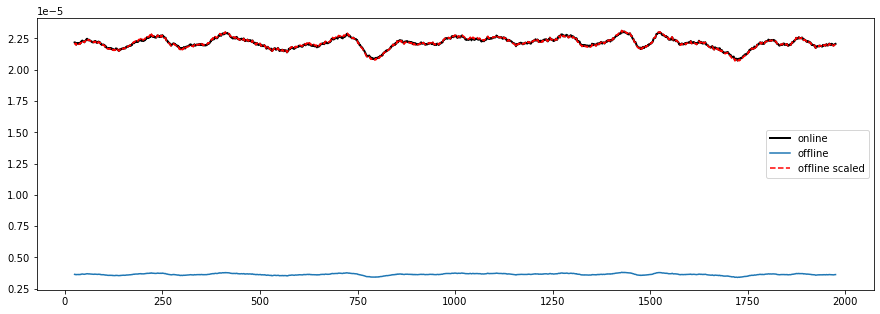

In [104]:
aa = np.ma.std(orig_30y_meanAdjusted[100:-100])
bb = np.ma.std(full_30y_meanAdjusted[100:-100])

print(aa)
print(bb)
print(bb / aa)

print(stock_var_compute['tos'].shape)
print(stock_var_compute['sos'].shape)
print(stock_var_compute['fgco2'].shape)

# ratio = (full_30y_meanAdjusted[100:-100] / orig_30y_meanAdjusted[100:-100]).mean()
ratio = (orig_30y_meanAdjusted / full_30y_meanAdjusted)[100:-100].mean()

plt.figure(figsize=(15, 5))
plt.plot(orig_30y_meanAdjusted, label='online', color='k', lw=2)
plt.plot(full_30y_meanAdjusted, label='offline')
plt.plot(full_30y_meanAdjusted * ratio, linestyle='--', color='r', label='offline scaled')
plt.legend()

print(ratio, 1/ratio)

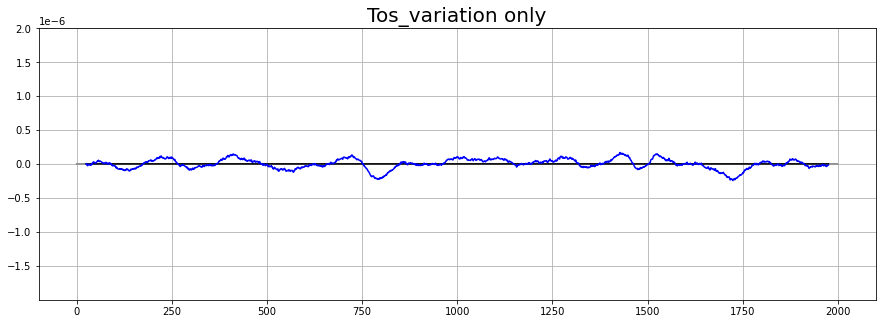

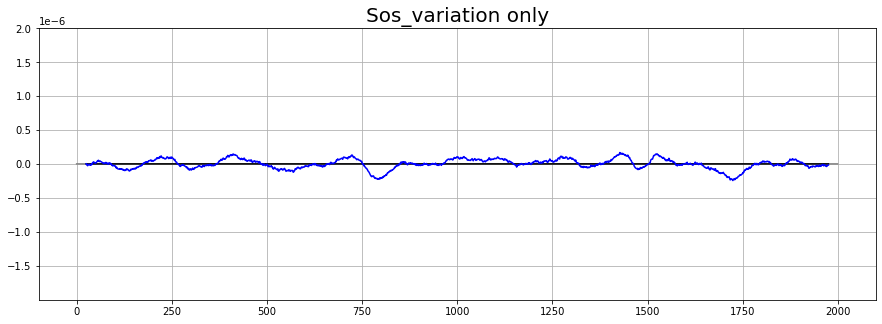

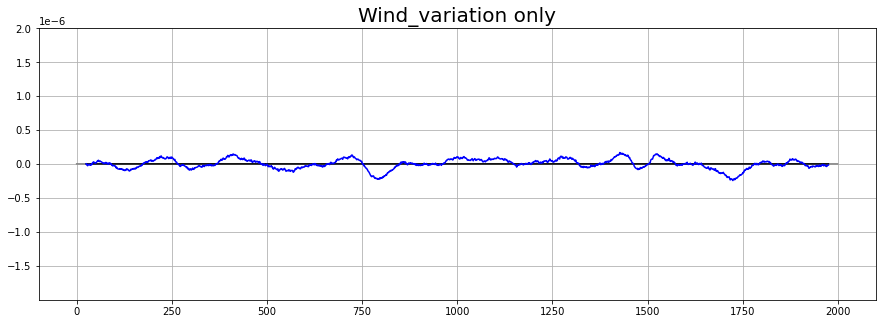

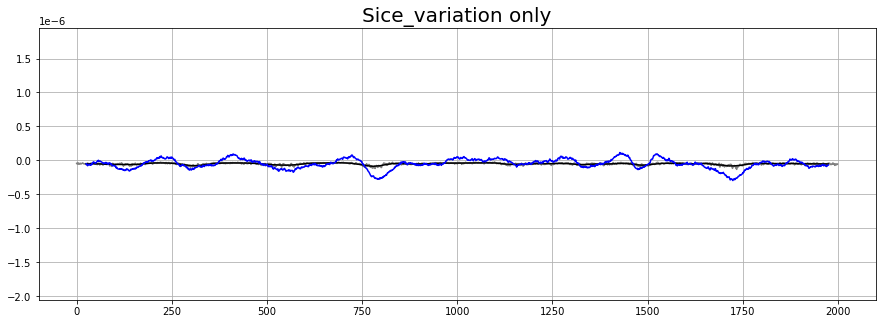

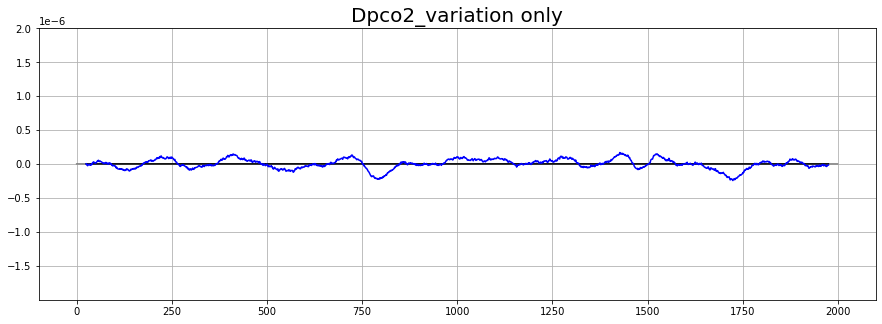

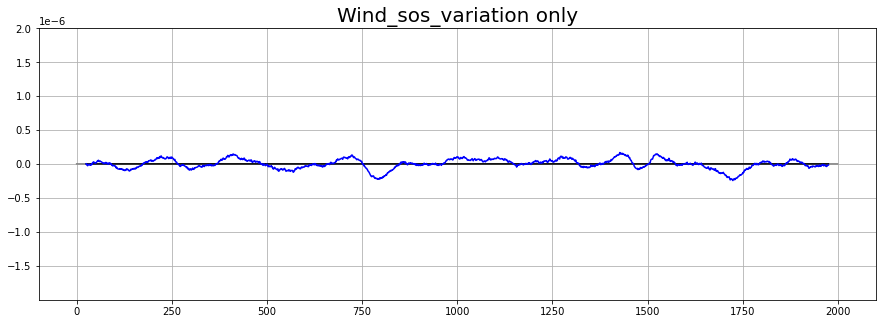

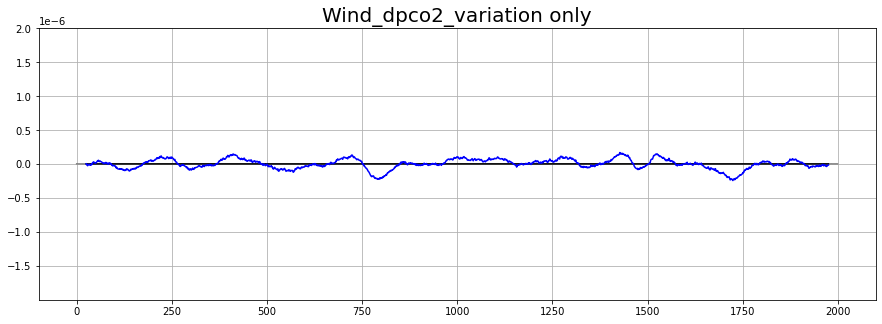

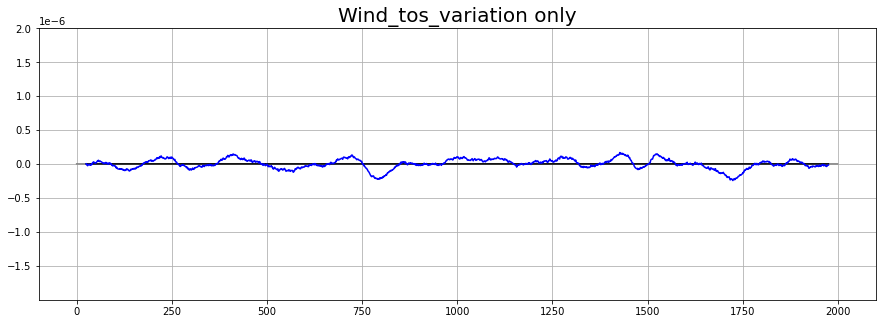

In [23]:
### Plot contributions
stock_variation_centennal = dict()
stock_variation_interannual = dict()

stock_variation_interannual.update({'fgco2' : ts_stock_annual['fgco2']})
stock_variation_centennal.update({'fgco2' : fgco2_calc_100yr})

ylim = np.array((-2e-6, 2e-6))

for contrib in list_variation:
    to_plot = stock_variation[contrib]
    average_30y = moving_average(to_plot, yr_window)
    
    full = stock_variation['fgco2']
    full_30y = moving_average(full, yr_window)    
    full_30y_meanAdjusted = full_30y.copy()
    full_30y_meanAdjusted -= np.ma.masked_invalid(full_30y_meanAdjusted).mean()
    full_30y_meanAdjusted += np.ma.masked_invalid(average_30y).mean()
    
    fig = plt.figure(figsize = (15,5))
    plt.plot(to_plot, c = 'grey')
    plt.plot(average_30y, c = 'black')
#     plt.plot(full, c = 'red', label='full calc')
    plt.plot(full_30y_meanAdjusted, c = 'blue', label='full calc 30y mean-adjusted')
    plt.grid()
    plt.ylim(ylim + to_plot.mean())
    plt.title('%s only'%contrib, fontsize = 20)
    plt.show()
    
    average_30y = moving_average(to_plot, yr_window, Fill = False)
    stock_variation_centennal.update({contrib : average_30y})
    
    ts_interannual = to_plot[~np.isnan(ts_100y)] - average_30y
    stock_variation_interannual.update({contrib : ts_interannual})

var_variation = get_variance(stock_variation, list_variation + ['fgco2'])
var_variation_interannual = get_variance(stock_variation_interannual, list_variation + ['fgco2'])
var_variation_centennal = get_variance(stock_variation_centennal, list_variation + ['fgco2'])
var_ratio_variation = (var_variation_centennal - var_variation/yr_window)/var_variation * 100

# VI -  Correlations : Figures 16 & 17

In [24]:
def get_correlation(dict_looked_at, list_looked_at, reference, cleaning = True, filtering = False):
    # Initialisation
    corrcoeff_stock = []
    
    for name in list_looked_at:
        #Prepping files for correlation
        var_arr = dict_looked_at[name]
        if cleaning:
            var_arr = clean_ts_for_spectral_analysis(var_arr, rescale = False)
        if filtering:
            var_arr = moving_average(var_arr, 2, Fill = False)
    
        var_arr -= var_arr.mean(); var_arr /= var_arr.std()
        
        # Same size for all
        nsamples = min(var_arr.size, reference.size)
        reference = reference[-nsamples:]
        var_arr = var_arr[-nsamples:]
        delay_arr = np.linspace(-0.5*nsamples, 0.5*nsamples, nsamples)

        ### Compute
        xcorr = signal.correlate(reference, var_arr, mode = 'same') / np.sqrt(signal.correlate(reference, reference, mode='same')[int(nsamples/2)] * signal.correlate(var_arr, var_arr, mode='same')[int(nsamples/2)])
        delay = delay_arr[np.argmax(np.abs(xcorr))]

        min_corr = np.min(xcorr)
        max_corr = np.max(xcorr)
        
        if np.abs(delay) > 50:
            print('%s not in phase'%name)
            print(stats.pearsonr(reference, var_arr))
            corrcoeff_stock.append(stats.pearsonr(reference, var_arr)[0])
            
        elif np.abs(max_corr) > np.abs(min_corr):
            corrcoeff_stock.append(max_corr)
        else:
            corrcoeff_stock.append(min_corr)
        
    print(corrcoeff_stock)
    return corrcoeff_stock

def get_reference(dict_looked_at, ref_name = 'fgco2'):
    reference = dict_looked_at[ref_name]
    if cleaning:
        reference = clean_ts_for_spectral_analysis(reference, rescale = False)
    if filtering:
        reference = moving_average(reference, 2, Fill = False)
    reference -= reference.mean(); reference /= reference.std()
    return reference

ts_stock = dict()
var_names_looked_at

stock_contrib = dict()
list_contribution = ['K0_contribution', 'Wind_contribution', 'Sice_contribution', 'Schmidt_contribution', 'Dpco2_contribution'] 

stock_scenario = dict()
list_scenario = ['K0_constant', 'Wind_constant', 'Sice_constant', 'Schmidt_constant', 'Dpco2_constant'] 

stock_constant = dict()
list_constant = ['K0_constant', 'Wind_constant', 'Sice_constant', 'Schmidt_constant', 'Dpco2_constant'] 

stock_variation = dict()
list_variation = ['Tos_variation', 'Sos_variation', 'Wind_variation', 'Sice_variation', 'Dpco2_variation']

In [25]:
legend_name = {'tos' : 'SST',
              'siconc' : 'Sea-Ice',
              'dpco2' : 'dPCO2',
              'sfcWind' : 'Wind',
              'sos' : 'SSS',
              'Tos_variation' : 'SST_variation',
              'Sos_variation' : 'SSS_variation',
              'Sice_variation' : 'Sea-Ice_variation',
              'Wind_variation' : 'Wind_variation',
              'Dpco2_variation' : 'dPCO2_variation',
              'Wind_sos_variation' : 'Wind_sos_variation',
               'Wind_tos_variation' : 'Wind_tos_variation',
               'Wind_dpco2_variation' : 'Wind_dpco2_variation',
              'TOS_constant' : 'SST_constant',
              'SOS_constant' : 'SSS_constant',
              'Sice_constant' : 'Sea-Ice_constant',
              'Wind_constant' : 'Wind_constant',
              'Dpco2_constant' : 'dPCO2_constant'}    

[-0.35213541305501794, -0.24036019894609442, -0.08481986824010261, 0.7364825950793101, 0.6143785278979703]
[0.7633392349407825, 0.8138506832245652, -0.7747501585302419, 0.8841239251881539, -0.6453760332967322]


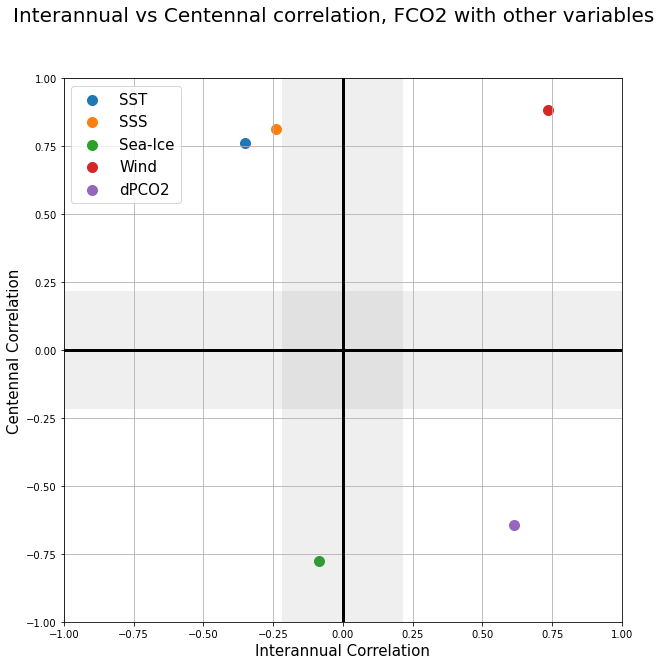

In [26]:
 # ---------------------------- FGCO2 ---------------------- #
cleaning = True
filtering = False
corr_thresholdx = 0.217
corr_thresholdy = 0.217

### Lists and 
list_looked_at = var_names_looked_at
dict_looked_at = ts_stock_annual

### Reference    
reference = get_reference(dict_looked_at)

### Correlation
corr_coeff1 = get_correlation(dict_looked_at, list_looked_at, reference)

### Lists and dic
list_looked_at = var_names_looked_at
dict_looked_at = ts_stock_100y

### Reference    
reference = get_reference(dict_looked_at)

### Correlation
corr_coeff2 = get_correlation(dict_looked_at, list_looked_at, reference)


### Plot
fig, ax = plt.subplots(figsize = (10,10))

ax.axhspan(-corr_thresholdy, corr_thresholdy, facecolor='0.4', alpha = 0.1)
ax.axvspan(-corr_thresholdx, corr_thresholdx, facecolor='0.4', alpha = 0.1)

for i in range(len(list_looked_at)):
    ax.scatter(corr_coeff1[i], corr_coeff2[i], s = 100, label = legend_name[list_looked_at[i]])

ax.axhline(linewidth=3, color = "black")       
ax.axvline(linewidth=3, color = "black") 



ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.legend(loc = 'upper left',prop={'size': 15})
fig.suptitle('Interannual vs Centennal correlation, FCO2 with other variables', fontsize=20)
ax.set_xlabel('Interannual Correlation', fontsize = 15)
ax.set_ylabel('Centennal Correlation', fontsize = 15)
ax.grid()
plt.show()




[0.9964887969096329, 0.996325786586811, 0.7488920331885398, 0.9133275241399933, 0.681765532959417]
[0.9985279442869529, 0.9996007994702736, 0.8068563736509624, -0.47735918974750335, 0.8661545697902867]


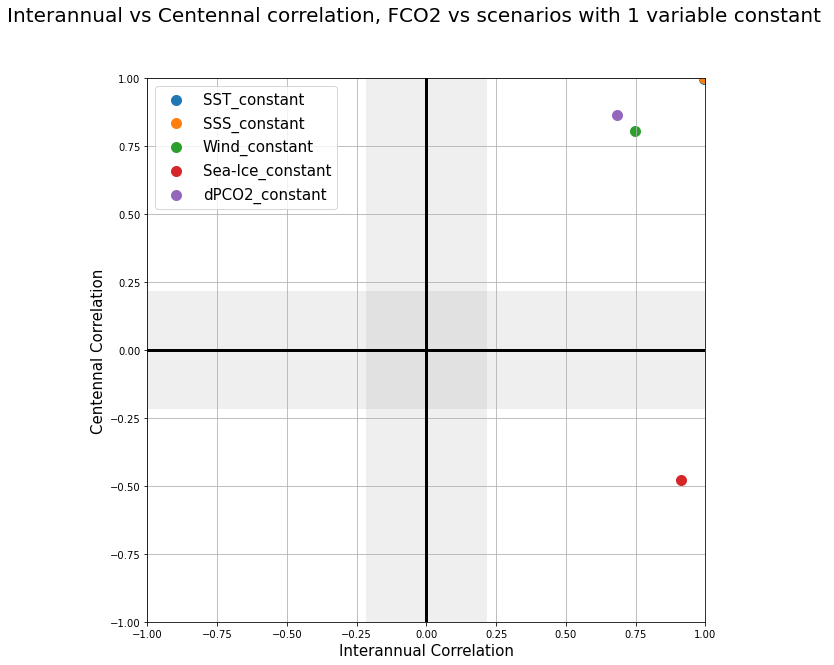

In [27]:
 # ---------------------------- FGCO2 ---------------------- #
cleaning = True
filtering = False
corr_thresholdx = 0.217
corr_thresholdy = 0.217

### Lists and 
list_looked_at = list_scenario
dict_looked_at = stock_scenario_interannual

### Reference    
reference = get_reference(dict_looked_at)

### Correlation
corr_coeff1 = get_correlation(dict_looked_at, list_looked_at, reference)

### Lists and dic
list_looked_at = list_scenario
dict_looked_at = stock_scenario_centennal


### Reference    
reference = get_reference(dict_looked_at)

### Correlation
corr_coeff2 = get_correlation(dict_looked_at, list_looked_at, reference)


### Plot
fig, ax = plt.subplots(figsize = (10,10))

ax.axhspan(-corr_thresholdy, corr_thresholdy, facecolor='0.4', alpha = 0.1)
ax.axvspan(-corr_thresholdx, corr_thresholdx, facecolor='0.4', alpha = 0.1)

for i in range(len(list_looked_at)):
    ax.scatter(corr_coeff1[i], corr_coeff2[i], s = 100, label = legend_name[list_looked_at[i]])

ax.axhline(linewidth=3, color = "black")       
ax.axvline(linewidth=3, color = "black") 



ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.legend(loc = 'upper left', prop={'size': 15})
fig.suptitle('Interannual vs Centennal correlation, FCO2 vs scenarios with 1 variable constant \n', fontsize=20)
ax.set_xlabel('Interannual Correlation', fontsize = 15)
ax.set_ylabel('Centennal Correlation', fontsize = 15)
ax.grid()
plt.show()




[0.32724174353321744, 0.2391241556539686, 0.7171373889387751, 0.08481986959634191, 0.614378527515716, 0.7192986571989911, 0.9196137536988462, 0.721976546891383]
[-0.784882613163893, -0.8332396264154298, 0.9091869323338636, 0.7933345502678273, -0.663930078673025, 0.9084213780821566, -0.4263918557015407, 0.9085262362170923]


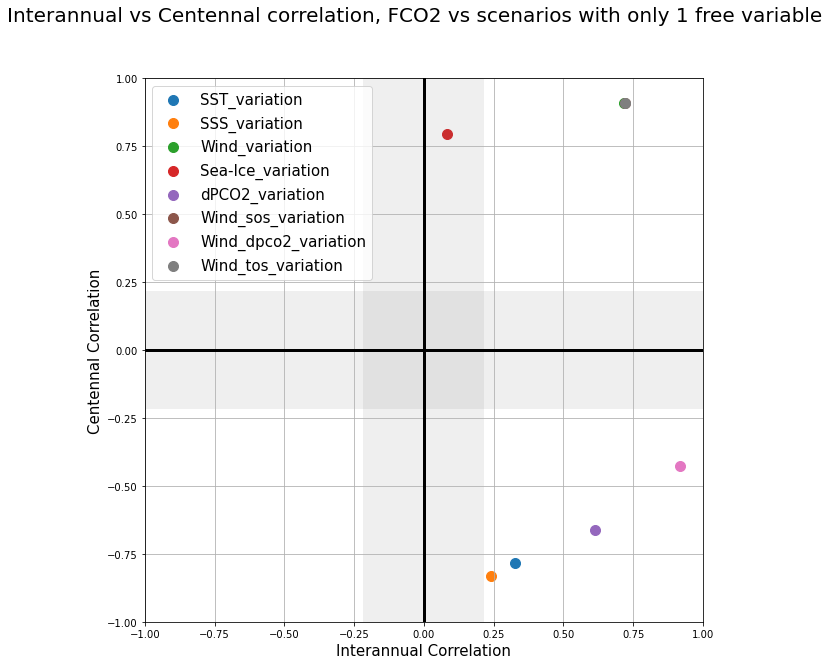

In [28]:
 # ---------------------------- FGCO2 ---------------------- #
cleaning = True
filtering = False
corr_thresholdx = 0.217
corr_thresholdy = 0.217

### Lists and 
list_looked_at = list_variation
dict_looked_at = stock_variation_interannual

### Reference    
reference = get_reference(dict_looked_at)

### Correlation
corr_coeff1 = get_correlation(dict_looked_at, list_looked_at, reference)

### Lists and dic
list_looked_at = list_variation
dict_looked_at = stock_variation_centennal


### Reference    
reference = get_reference(dict_looked_at)

### Correlation
corr_coeff2 = get_correlation(dict_looked_at, list_looked_at, reference)


### Plot
fig, ax = plt.subplots(figsize = (10,10))

ax.axhspan(-corr_thresholdy, corr_thresholdy, facecolor='0.4', alpha = 0.1)
ax.axvspan(-corr_thresholdx, corr_thresholdx, facecolor='0.4', alpha = 0.1)

for i in range(len(list_looked_at)):
    ax.scatter(corr_coeff1[i], corr_coeff2[i], s = 100, label = legend_name[list_looked_at[i]])

ax.axhline(linewidth=3, color = "black")       
ax.axvline(linewidth=3, color = "black") 



ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.legend(loc = 'upper left', prop={'size': 15})
fig.suptitle('Interannual vs Centennal correlation, FCO2 vs scenarios with only 1 free variable', fontsize=20)
ax.set_xlabel('Interannual Correlation', fontsize = 15)
ax.set_ylabel('Centennal Correlation', fontsize = 15)
ax.grid()
plt.show()




# VI - Figure 11 : Map variance ratio

In [29]:
import scipy.integrate as integrate
from statsmodels.regression.linear_model import yule_walker as yule_walker

time_intervals = [(2,5),(5,15),(12,30),(30,50),(50,90),(90,120),(120,180),(180,300)]
freq_intervals = [(1/x[0],1/x[1]) for x in time_intervals]
name_intervals =[3, 10, 22, 40, 75, 110, 150, 230]


def integrate_sig(y,x,interval = None):
    '''
    Y - array-like data, PSD of the signal
    X - array-like data, frequencies of the PSD signal
    interval - tuple, interval on which to integrate
    '''
    if interval is None:
        return integrate.simps(y,x)
    
    x_restricted = x[(x>interval[1]) & (x<interval[0])]
    y_restricted = y[(x>interval[1]) & (x<interval[0])]
    
    return integrate.simps(y_restricted, x_restricted)


def clean_cell_ts(var_arr, rescale = False, check = False):
    try:
        N = len(var_arr)
        var_minus_mean = var_arr - var_arr.mean()
        X = np.arange(0,N,1).reshape((-1,1))
    
        model = LinearRegression()
        model.fit(X,var_minus_mean)
        trend = model.predict(X)
        detrend = var_minus_mean - trend
        return detrend
    
    except ValueError:
        return var_arr



In [30]:
# Get data for variable var_name

var_name = 'fgco2'

for time_bounds in time_segs:
    if time_bounds[0] == 0 :
        # Get all data and filter it
        print('Getting data for %s for timesteps %s'%(var_name, time_bounds))
        data = xr.open_dataset(files_vars[var_name], decode_times = False).isel(time = slice(time_bounds[0], time_bounds[1]))[var_name].data
        data = np.reshape(data,(-1,12,180,360))    
        data = data.sum(axis = 1)/12
        
        # Add it to the dict
        annual_map_data = data
        del data
        
    else : 
        # Get all data and filter it
        print('Getting data for %s for timesteps %s'%(var_name, time_bounds))
        data = xr.open_dataset(files_vars[var_name], decode_times = False).isel(time = slice(time_bounds[0], time_bounds[1]))[var_name].data
        data = np.reshape(data,(-1,12,180,360))    
        data = data.sum(axis = 1)/12

        # Add it to the dict
        annual_map_data = np.concatenate([annual_map_data, data])
        del data

Getting data for fgco2 for timesteps (0, 12000, 12000)
Getting data for fgco2 for timesteps (12000, 24000, 12000)


In [31]:
detrend = True

if detrend == True:
    annual_map_data = np.apply_along_axis(clean_cell_ts, 0, annual_map_data) 
    print('data cleaned')


data cleaned


In [32]:
# Centennal rolling mean 
decadal = False
n = 50
ts_2D_100y = np.cumsum(annual_map_data, axis = 0, dtype=float)
ts_2D_100y[n:,:] = ts_2D_100y[n:,:] - ts_2D_100y[:-n,:]
ts_2D_100y =  ts_2D_100y[n - 1:,:] / n

if decadal:
    n2 = 6
    ts_2D_10y = np.cumsum(annual_map_data, axis = 0, dtype=float)
    ts_2D_10y[n2:,:] = ts_2D_10y[n2:,:] - ts_2D_10y[:-n2,:]
    ts_2D_10y =  ts_2D_10y[n2 - 1:,:] / n2
    ts_2D_10y_corr = ts_2D_10y[n//2- n2//2:-(n//2-1) + (n2//2-1)] - ts_2D_100y
    

# Variance 
if decadal:
    var_2D_100y = ts_2D_10y_corr.var(axis = 0)
    var_2D_annual = (annual_map_data[n2//2:-(n2//2-1)] - ts_2D_10y).var(axis = 0)
else:
    var_2D_100y = ts_2D_100y.var(axis = 0)
    var_2D_annual = (annual_map_data[n//2:-(n//2-1)] - ts_2D_100y).var(axis = 0)
            
var_ratio = var_2D_100y / var_2D_annual * 100
var_glob = annual_map_data.var(axis = 0)
var_ratio2 = (var_2D_100y - var_glob/n)/var_glob * 100
print(var_ratio.shape)

(180, 360)


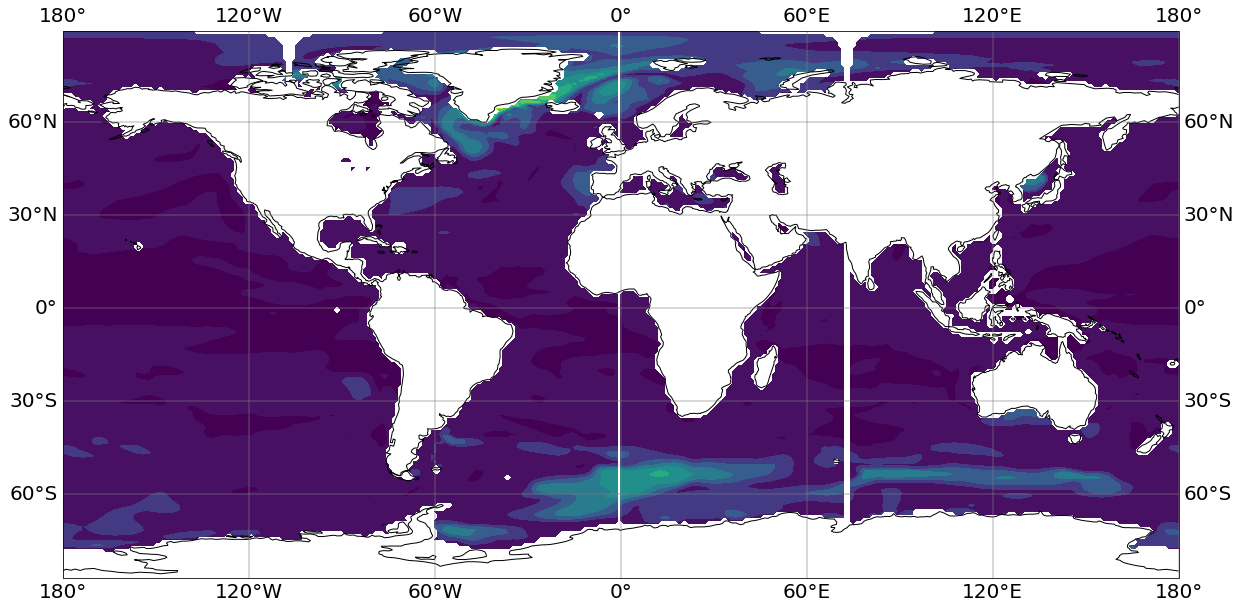

In [33]:
fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection=ccrs.PlateCarree())

bounds = np.linspace(0,50,25)
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend = 'max')

ax.contourf(lons, lats, var_ratio2, cmap = cmap, norm = norm) 

ax.coastlines()
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 2, color = 'gray', alpha = 0.3)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

plt.show()

In [34]:
print(annual_map_data.shape)

(2000, 180, 360)
